In [1]:
import opendatasets as op
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from torchvision import models

In [2]:
#op.download("https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time")

In [3]:
data_dir = "/home/meghal/Personal/Konverge_AI/Training/Deep Learning with Pytorch (Zero-to-GANs)/Project/best-artworks-of-all-time/images/images"

In [4]:
os.listdir("/home/meghal/Personal/Konverge_AI/Training/Deep Learning with Pytorch (Zero-to-GANs)/Project/best-artworks-of-all-time/images/images")

['Vincent_van_Gogh',
 'Peter_Paul_Rubens',
 'Alfred_Sisley',
 'Rene_Magritte',
 'Camille_Pissarro',
 'Pierre-Auguste_Renoir',
 'Henri_de_Toulouse-Lautrec',
 'William_Turner',
 'Henri_Rousseau',
 'Pieter_Bruegel',
 'Frida_Kahlo',
 'Andrei_Rublev',
 'Francisco_Goya',
 'Salvador_Dali',
 'Paul_Cezanne',
 'Marc_Chagall',
 'Piet_Mondrian',
 'Paul_Gauguin',
 'Caravaggio',
 'Henri_Matisse',
 'El_Greco',
 'Michelangelo',
 'Hieronymus_Bosch',
 'Pablo_Picasso',
 'Titian',
 'Edgar_Degas',
 'Albrecht_DuΓòá├¬rer',
 'Diego_Velazquez',
 'Kazimir_Malevich',
 'Diego_Rivera',
 'Eugene_Delacroix',
 'Raphael',
 'Sandro_Botticelli',
 'Edvard_Munch',
 'Albrecht_Du╠êrer',
 'Gustave_Courbet',
 'Joan_Miro',
 'Leonardo_da_Vinci',
 'Giotto_di_Bondone',
 'Edouard_Manet',
 'Jan_van_Eyck',
 'Amedeo_Modigliani',
 'Gustav_Klimt',
 'Claude_Monet',
 'Georges_Seurat',
 'Vasiliy_Kandinskiy',
 'Rembrandt',
 'Jackson_Pollock',
 'Mikhail_Vrubel',
 'Paul_Klee',
 'Andy_Warhol']

In [5]:
dataset = ImageFolder(data_dir)

In [6]:
len(dataset)

8774

In [7]:
dataset[1]

(<PIL.Image.Image image mode=RGB size=1494x2048 at 0x7F98A6FD4940>, 0)

In [8]:
dataset.classes

['Albrecht_DuΓòá├¬rer',
 'Albrecht_Du╠êrer',
 'Alfred_Sisley',
 'Amedeo_Modigliani',
 'Andrei_Rublev',
 'Andy_Warhol',
 'Camille_Pissarro',
 'Caravaggio',
 'Claude_Monet',
 'Diego_Rivera',
 'Diego_Velazquez',
 'Edgar_Degas',
 'Edouard_Manet',
 'Edvard_Munch',
 'El_Greco',
 'Eugene_Delacroix',
 'Francisco_Goya',
 'Frida_Kahlo',
 'Georges_Seurat',
 'Giotto_di_Bondone',
 'Gustav_Klimt',
 'Gustave_Courbet',
 'Henri_Matisse',
 'Henri_Rousseau',
 'Henri_de_Toulouse-Lautrec',
 'Hieronymus_Bosch',
 'Jackson_Pollock',
 'Jan_van_Eyck',
 'Joan_Miro',
 'Kazimir_Malevich',
 'Leonardo_da_Vinci',
 'Marc_Chagall',
 'Michelangelo',
 'Mikhail_Vrubel',
 'Pablo_Picasso',
 'Paul_Cezanne',
 'Paul_Gauguin',
 'Paul_Klee',
 'Peter_Paul_Rubens',
 'Pierre-Auguste_Renoir',
 'Piet_Mondrian',
 'Pieter_Bruegel',
 'Raphael',
 'Rembrandt',
 'Rene_Magritte',
 'Salvador_Dali',
 'Sandro_Botticelli',
 'Titian',
 'Vasiliy_Kandinskiy',
 'Vincent_van_Gogh',
 'William_Turner']

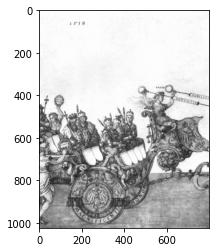

In [9]:
img, label = dataset[5]
plt.imshow(img, cmap='gray')

In [10]:
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(32),tt.RandomCrop(32), tt.ToTensor()]))

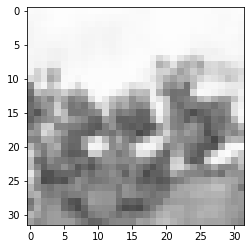

In [11]:
img, label = dataset[5]
plt.imshow(img.permute((1,2,0)))

In [12]:
val_pct = 0.2
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

val_size, train_size

(1754, 7020)

In [13]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [14]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

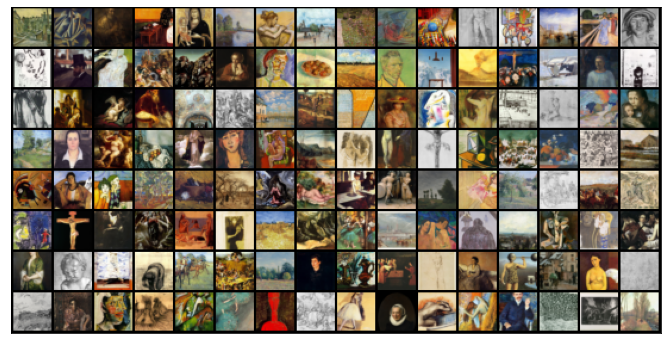

In [15]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
    
show_batch(train_dl)

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cpu')

In [18]:
img, label = dataset[0]
img

tensor([[[0.6118, 0.6118, 0.6118,  ..., 0.5569, 0.5373, 0.5412],
         [0.5882, 0.5961, 0.6039,  ..., 0.5098, 0.4980, 0.5216],
         [0.5490, 0.5647, 0.5725,  ..., 0.4902, 0.4745, 0.4745],
         ...,
         [0.6902, 0.6941, 0.7020,  ..., 0.6157, 0.5961, 0.6039],
         [0.7137, 0.6980, 0.6941,  ..., 0.6706, 0.6588, 0.6471],
         [0.7294, 0.7098, 0.7020,  ..., 0.6863, 0.6667, 0.6745]],

        [[0.6118, 0.6118, 0.6118,  ..., 0.5569, 0.5373, 0.5412],
         [0.5882, 0.5961, 0.6039,  ..., 0.5098, 0.4980, 0.5216],
         [0.5490, 0.5647, 0.5725,  ..., 0.4902, 0.4745, 0.4745],
         ...,
         [0.6902, 0.6941, 0.7020,  ..., 0.6157, 0.5961, 0.6039],
         [0.7137, 0.6980, 0.6941,  ..., 0.6706, 0.6588, 0.6471],
         [0.7294, 0.7098, 0.7020,  ..., 0.6863, 0.6667, 0.6745]],

        [[0.6118, 0.6118, 0.6118,  ..., 0.5569, 0.5373, 0.5412],
         [0.5882, 0.5961, 0.6039,  ..., 0.5098, 0.4980, 0.5216],
         [0.5490, 0.5647, 0.5725,  ..., 0.4902, 0.4745, 0.

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [20]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [22]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [23]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [24]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 3.930919647216797, 'val_acc': 0.014186508022248745}]

In [25]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
# history += fit(epochs, max_lr, model, train_dl, val_dl, opt_func)
history += fit(epochs, max_lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 6.1828, val_loss: 3.7619, val_acc: 0.0957
Epoch [1], train_loss: 3.7606, val_loss: 3.4300, val_acc: 0.1414


: 

: 

: 

: 

In [ ]:
class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = ResNet34(len(dataset.classes))
to_device(model, device);

history = [evaluate(model, val_dl)]
history

[{'val_loss': 4.174091815948486, 'val_acc': 0.02884424664080143}]

In [ ]:
img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(img_size),tt.RandomCrop(img_size), tt.ToTensor(), tt.Normalize(*imagenet_stats)]))

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])

batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)



In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 4.202328681945801, 'val_acc': 0.012834821827709675}]

In [ ]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/110 [00:00<?, ?it/s]

: 

: 

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

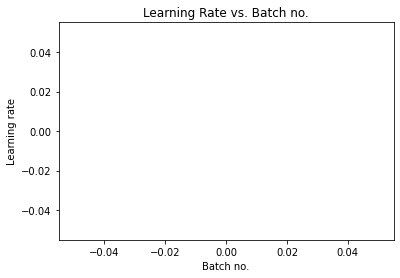

In [ ]:
plot_lrs(history)

In [ ]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

In [ ]:
def predict_image(img, model, train_ds):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: Albrecht_DuΓòá├¬rer (0)
Target:  Albrecht_DuΓòá├¬rer
Predicted:  Henri_Rousseau


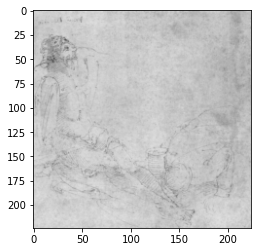

In [ ]:
img, label = dataset[10]
show_image(img, label)
pred = predict_image(img, model, dataset)
print("Target: ", dataset.classes[label]) 
print("Predicted: ", pred)